In [ ]:
# ECGR 4106 HW1
# Author: Lucas Therrien
# Student ID #801122089
# GitHub Link: https://github.com/lucastherrien/ECGR4106HW1



##_________________________________________##
## Setup
##_________________________________________##

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbconvert
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer 
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
import seaborn as sns
from matplotlib.colors import ListedColormap
import torch.nn as nn
import torch
from torch import optim
from d2l import torch as d2l
#Suppress all warnings because they annoy me
import warnings
warnings.filterwarnings("ignore")

In [ ]:
##_________________________________________##
## Problem 1
##_________________________________________##

In [9]:
fashion_train = pd.read_csv('fashion-mnist_train.csv')
x_train = fashion_train.loc[:,fashion_train.columns != "label"]
x_train = torch.tensor(np.array(x_train)).unsqueeze(1)
y_train = fashion_train.loc[:,fashion_train.columns == "label"]
y_train = torch.tensor(np.array(y_train)).unsqueeze(1)
fashion_test = pd.read_csv('fashion-mnist_test.csv')
x_test = fashion_test.loc[:,fashion_test.columns != "label"]
x_test = torch.tensor(np.array(x_test)).unsqueeze(1)
y_test = fashion_test.loc[:,fashion_test.columns == "label"]
y_test = torch.tensor(np.array(y_test)).unsqueeze(1)
#x_train.head()


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [62]:
class Fashion_Data(d2l.DataModule):
    def __init__(self,batch_size,train,val):
        super().__init__()
        self.save_hyperparameters()
    def get_dataloader(self, train):
        label = 'label'
        data = self.train if train else self.val
        get_x_tensor = lambda x: torch.tensor(x.values,dtype=torch.float32)
        get_y_tensor = lambda y: torch.tensor(y.values,dtype=torch.long)
        x = get_x_tensor(data.drop(columns=[label]))
        x = (x-x.mean())/x.std()
        y = get_y_tensor(data[label])
        tensors = (x,y)
        return super().get_tensorloader(tensors,train)

In [94]:

class MLP(d2l.Classifier):
    def __init__(self,num_outputs,num_hiddens,lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),nn.LazyLinear(num_hiddens),
                                nn.ReLU(),nn.LazyLinear(num_outputs))
        self.net.parameters
        self.lr = lr
    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(),self.lr) 
        return optimizer
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        acc = self.accuracy(self(*batch[:-1]), batch[-1])
        self.plot('accuracy', acc, train=True)
        return l


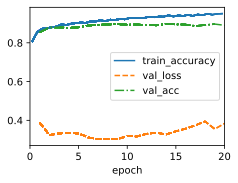

In [110]:
# 1A
fashion_data = Fashion_Data(64,fashion_train,fashion_test)
a_model = MLP(num_outputs=10,num_hiddens=256,lr=0.001)
print(a_model.layer_summary)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model=a_model,data=fashion_data)

In [111]:
a1_weights = a_model.net[1].state_dict()
a2_weights = a_model.net[3].state_dict()

In [ ]:
# Model began overfitting at around 12 epochs

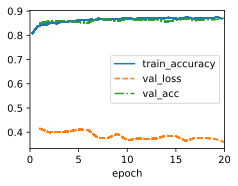

In [91]:
# 1b
class WeightDecay(d2l.Classifier):
    def __init__(self,num_outputs,num_hiddens, lambd, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),nn.LazyLinear(num_hiddens),
                                nn.ReLU(),nn.LazyLinear(num_outputs))
        self.lr = lr
        self.lambd = lambd
    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(),self.lr,weight_decay=self.lambd) 
        return optimizer
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        acc = self.accuracy(self(*batch[:-1]), batch[-1])
        self.plot('accuracy', acc, train=True)
        return l


model = WeightDecay(num_outputs=10,num_hiddens=256,lambd=0.005, lr=0.001)
trainer.fit(model, fashion_data)


In [ ]:
# Validation Accuracy appears to be somewhat (~3%) better with weight decay introduced and marginally better validation loss

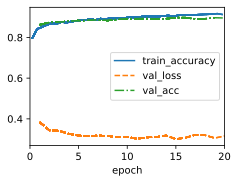

In [90]:
# 1c
class DropoutModel(d2l.Classifier):
    def __init__(self,num_outputs,num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),nn.LazyLinear(num_hiddens),nn.Dropout(0.3),
                                nn.ReLU(),nn.LazyLinear(num_outputs))
        self.lr = lr
    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters()) 
        return optimizer
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        acc = self.accuracy(self(*batch[:-1]), batch[-1])
        self.plot('accuracy', acc, train=True)
        return l


model = DropoutModel(num_outputs=10,num_hiddens=256, lr=0.001)
trainer.fit(model, fashion_data)

In [ ]:
# Much better validation loss and seemingly much better accuracy than both the weight decay and standard models

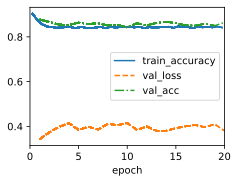

In [113]:
# 1d
class DropoutandWDModel(d2l.Classifier):
    def __init__(self,num_outputs,num_hiddens,lambd,lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),nn.LazyLinear(num_hiddens),nn.Dropout(0.3),
                                nn.ReLU(),nn.LazyLinear(num_outputs))
        self.lr = lr
        self.lambd = lambd
        self.net[1].load_state_dict(a1_weights)
        self.net[4].load_state_dict(a2_weights)
    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(),self.lr,weight_decay=self.lambd) 
        return optimizer
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        acc = self.accuracy(self(*batch[:-1]), batch[-1])
        self.plot('accuracy', acc, train=True)
        return l


model = DropoutandWDModel(num_outputs=10,num_hiddens=256,lambd=0.005,lr=0.001)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, fashion_data)



In [ ]:
# Validation loss went up, which leads me to believe that the weights from 1a were not great

In [ ]:
##_________________________________________##
## Problem 2
##_________________________________________##

In [116]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
    def preprocess(self):
        # Remove the ID and label columns
        label = 'SalePrice'
        features = pd.concat(
            (self.raw_train.drop(columns=['Id', label]),
            self.raw_val.drop(columns=['Id'])))
        # Standardize numerical columns
        numeric_features = features.dtypes[features.dtypes != 'object'].index
        features[numeric_features] = features[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        # Replace NAN numerical features by 0
        features[numeric_features] = features[numeric_features].fillna(0)
        # Replace discrete features by one-hot encoding.
        features = pd.get_dummies(features, dummy_na=True)
        # Save preprocessed features
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train[label] = self.raw_train[label]
        self.val = features[self.raw_train.shape[0]:].copy()
    def get_dataloader(self, train):
        label = 'SalePrice'
        data = self.train if train else self.val
        if label not in data: return
        get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
        # Logarithm of prices
        tensors = (get_tensor(data.drop(columns=[label])),  # X
                    torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
        return self.get_tensorloader(tensors, train)

def k_fold_data(data, k):
        rets = []
        fold_size = data.train.shape[0] // k
        for j in range(k):
            idx = range(j * fold_size, (j+1) * fold_size)
            rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                    data.train.loc[idx]))
        return rets
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

In [118]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)
data.preprocess()
data.train.shape

(1460, 81)
(1459, 80)


(1460, 332)

average validation log mse = 0.1825955632328987


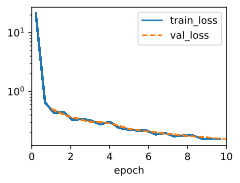

In [119]:
# Baseline Model
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [126]:
# 2a. The features are scaled down. For example on this dataset the MSSubclass feature is scaled down from 10^1 to fit in a -1 to 1 axis
data.raw_train["MSSubClass"].head()

0    60
1    20
2    60
3    70
4    60
Name: MSSubClass, dtype: int64

In [127]:
data.train["MSSubClass"].head()

0    0.067320
1   -0.873466
2    0.067320
3    0.302516
4    0.067320
Name: MSSubClass, dtype: float64

In [167]:
preds = []
class DropoutandWDModel(d2l.SoftmaxRegression):
    def __init__(self,num_hiddens,do,lambd,lr):
        super().__init__(num_outputs=1,lr=lr)
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),nn.LazyLinear(num_hiddens),nn.Dropout(do),
                                nn.ReLU(),nn.LazyLinear(1))
        self.lr = lr
        self.lambd = lambd
    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(),self.lr,weight_decay=self.lambd) 
        return optimizer
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        acc = self.accuracy(self(*batch[:-1]), batch[-1])
        self.plot('accuracy', acc, train=True)
        return l
    def loss(self, y_hat, y):
        """Defined in :numref:`sec_linear_concise`"""
        fn = nn.MSELoss()
        return fn(y_hat, y)
    

def k_fold(trainer, data, k, num_hiddens,do,lambd,lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = DropoutandWDModel(num_hiddens,do,lambd,lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models


average validation log mse = 0.03237919364124537


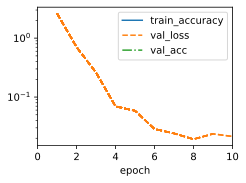

In [168]:
# 2b
#data.train["SalePrice"].head()
trainer = d2l.Trainer(max_epochs=10)
# drouput and lambda set to 0, but still using the same function
b_models = k_fold(trainer, data, k=5,num_hiddens=256,do=0,lambd=0,lr=0.01)

In [ ]:
# This newer, more complex model was far more accurate and took only a few seconds more to train. 

average validation log mse = 0.07973214864730835


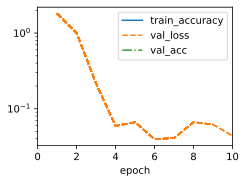

In [158]:
# 2c
trainer = d2l.Trainer(max_epochs=10)
c_models = k_fold(trainer, data, k=5,num_hiddens=256,do=0.05,lambd=0.005,lr=0.01)

In [164]:
# introducing dropout and weight decay only seemed to make it less accurate

In [169]:
# 2d
preds = [model(torch.tensor(data.val.values, dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

# Kaggle score : 0.22191